In [544]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)

In [545]:
"""
Load data.
Change path variable to your location of CSV files.
"""

path = "./data/"

df_zones = pd.read_csv(path + "zona_censal_comuna.csv")
df_demos = pd.read_csv(path + "age_demo_comunas.csv")
df_qua = pd.read_csv(path + "matrix_cuarentena_comunas_semanas.csv")
df_inf = pd.read_csv(path + "dp1_contagiados_por_comuna.csv")
df_mob1 = pd.read_csv(path + "od_zones_weeks_20200301.enc.csv")
df_mob2 = pd.read_csv(path + "od_zones_weeks_20200401.enc.csv")
df_mob = pd.concat([df_mob1, df_mob2])

In [961]:
# normalize = False
normalize = True
log_trick = False
# log_trick = True

### Census zones & Communes

In [962]:
"""
Census zone information (only for Santiago).

Relevant columns:
    GEOCODIGO = census zone id
    COMUNA    = commune id
"""
df_zones

,OBJECTID,REGION,PROVINCIA,NOM_COMUNA,COMUNA,GEOCODIGO
0,1,13,134,PAINE,13404,13404011003
1,2,13,134,PAINE,13404,13404011002
2,3,13,134,PAINE,13404,13404061004
3,4,13,134,PAINE,13404,13404061001
4,5,13,134,PAINE,13404,13404061002
...,...,...,...,...,...,...
1860,1861,13,136,EL MONTE,13602,13602031001
1861,1862,13,136,TALAGANTE,13601,13601021001
1862,1863,13,136,TALAGANTE,13601,13601021002
1863,1864,13,135,ALHUÉ,13502,13502011001


In [963]:
"""
Create dictionaries for (standardized) ID lookups of zones and communes.
"""
# Enumerate communes with standardized IDs (from 0 to 50)
df_coms = df_zones[["COMUNA","NOM_COMUNA"]].drop_duplicates()
dict_com_sid_com_info = {com_sid:com_info for com_sid, com_info in enumerate(zip(df_coms.COMUNA, df_coms.NOM_COMUNA))}
dict_com_id_com_sid = {com_id:com_sid for com_sid, com_id in enumerate(df_coms.COMUNA)}
dict_com_name_com_sid = {com_name:com_sid for com_sid, com_name in enumerate(df_coms.NOM_COMUNA)}

# Dictionary mapping census zone id to its commune standardized id
dict_zone_id_com_sid = {zone_id:dict_com_id_com_sid[com_id] for zone_id, com_id in zip(df_zones.GEOCODIGO, df_zones.COMUNA)}    

### Mobility data

In [964]:
"""
Logs of averaged amount of movement of individuals across census zones.

Relevant columns:
    mean_population_zone = weekly mean of daily number of individuals
                                that spend majority of their day in census zone [code_zone]
                                that live in census zone [home_zone]
    code_zone            = visiting census zone
    home_zone            = home census zone
    week                 = week of year
    time_block           = T1 - 10:00-13:00, T2 - 14:00-17:00
"""
df_mob

,mean_population_zone,code_zone,week,time_block,home_zone
0,154.800000,13124061022,9,T1,13124061005
1,14.200000,13101081001,9,T1,13126031003
2,12.800000,13123021005,9,T1,13120041002
3,26.800000,13114021002,9,T1,13114061001
4,44.200000,13114131005,9,T1,13114031002
...,...,...,...,...,...
4642958,1.666667,13130031001,17,T2,13112051010
4642959,1.666667,13119011005,17,T2,13106051001
4642960,1.666667,13301011001,17,T1,13104051001
4642961,1.666667,13119201001,17,T2,13124061005


In [965]:
"""
Create dataframe of edge information: (home zone, visiting zone, week, mean population)
Aggregate information into communes.
"""
t = df_mob.week.min()    # earliest week available
get_zone_com_sid = lambda i: dict_zone_id_com_sid[i]

df_edge_list = df_mob[["home_zone","code_zone","week","mean_population_zone"]]
df_edge_list = df_edge_list[df_edge_list["home_zone"] != df_edge_list["code_zone"]]    # remove intra-zone info
df_edge_list.columns = ['home_com', 'travel_com', 'week', 'mean_pop']
df_edge_list.loc[:,"home_com"] = df_edge_list.loc[:,"home_com"].apply(get_zone_com_sid)
df_edge_list.loc[:,"travel_com"] = df_edge_list.loc[:,"travel_com"].apply(get_zone_com_sid)
df_edge_list.loc[:,"week"] = df_edge_list.loc[:,"week"] - t    # zero index weeks

# Aggregate data by summing mean population of same edges in same week. Sum data from both time blocks.
df_edge_list = df_edge_list.groupby(['home_com','travel_com','week']).agg({'mean_pop':'sum'}).reset_index()

In [966]:
df_edge_list

,home_com,travel_com,week,mean_pop
0,0,0,0,2263.183333
1,0,0,1,2283.533333
2,0,0,2,2210.433333
3,0,0,3,2283.000000
4,0,0,4,4658.500000
...,...,...,...,...
21926,50,47,4,1.000000
21927,50,47,6,1.000000
21928,50,48,2,1.000000
21929,50,48,8,1.000000


In [987]:
"""
Create mobility matrix: A[i,j,t] 
"""
T = df_mob.week.max() - df_mob.week.min() + 1
N = len(dict_com_sid_com_info)
A = np.zeros((N, N, T))

edge_list = zip(df_edge_list.home_com, df_edge_list.travel_com, df_edge_list.week, df_edge_list.mean_pop)
for edge in edge_list:
    i, j, t, a_ijt = edge
    A[i,j,t] += a_ijt
    
# normalize entries by visit commune population size
if normalize:
#     get_com_sid = lambda i: dict_com_id_com_sid[i] if i in dict_com_id_com_sid else pd.NaT
#     df_pop = df_demos[["COMUNA","T_POB"]]
#     df_pop["COMUNA"] = df_pop.loc[:,"COMUNA"].apply(get_com_sid)
#     df_pop = df_pop.dropna()
#     dict_com_sid_pop = {sid:pop for sid, pop in zip(df_pop.COMUNA, df_pop.T_POB)}

#     for j in range(N):
#         A[:,j,:] = A[:,j,:] / dict_com_sid_pop[j]
    
    com_pop = np.zeros((N,T))
    for t in range(T):
        com_pop[:,t] = np.dot(A[:,:,t],np.ones(N))
        A[:,:,t] = A[:,:,t] / np.dot(A[:,:,t],np.ones(N))[:,None]

In [968]:
# Mobility matrix over 51 communes in Santiago over 9 time periods (weeks 9-17).
print(A.shape)

# Matrix is not sparse
print(np.count_nonzero(A), N*N*T)

(51, 51, 9)
21931 23409


### Infections data

In [969]:
"""
Logs of cumulative number of infections in each commune in Chile over differently spaced out days in weeks 14-19.

Relevant columns:
    Codigo comuna          = commune ID
    Date (e.g. 2020-03-30) = number of confirmed cases of COVID19 on that day.
"""
df_inf

,Unnamed: 0,Region,Codigo region,Comuna,Codigo comuna,Poblacion,2020-03-30,2020-04-01,2020-04-03,2020-04-06,...,2020-04-15,2020-04-17,2020-04-20,2020-04-24,2020-04-27,2020-05-01,2020-05-04,2020-05-08,2020-05-11,Tasa
0,0,Arica y Parinacota,15,Arica,15101,247552.0,6.0,6.0,12.0,41.0,...,124.0,134.0,166.0,224.0,270.0,297.0,310.0,328.0,353.0,142.6
1,1,Arica y Parinacota,15,Camarones,15102,1233.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Arica y Parinacota,15,General Lagos,15202,810.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Arica y Parinacota,15,Putre,15201,2515.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Tarapacá,1,Alto Hospicio,1107,129999.0,0.0,0.0,0.0,5.0,...,15.0,16.0,27.0,39.0,55.0,77.0,128.0,161.0,188.0,144.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,341,Magallanes,12,Punta Arenas,12101,141984.0,29.0,87.0,143.0,203.0,...,416.0,470.0,516.0,581.0,623.0,685.0,744.0,825.0,858.0,604.3
342,342,Magallanes,12,Rio Verde,12103,211.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
343,343,Magallanes,12,San Gregorio,12104,681.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,146.8
344,344,Magallanes,12,Timaukel,12303,282.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [970]:
"""
Aggregate infections data into weeks.
Only keep data for communes in Santiago.
"""
get_com_sid = lambda i: dict_com_id_com_sid[i] if i in dict_com_id_com_sid else pd.NaT
df_y = pd.DataFrame()
df_y["com"] = df_inf["Codigo comuna"]
df_y.loc[:,"com"] = df_y.loc[:,"com"].apply(get_com_sid)
# df_y["week14"] = df_inf["2020-03-30"] + df_inf["2020-04-01"] + df_inf["2020-04-03"]
# df_y["week15"] = df_inf["2020-04-06"] + df_inf["2020-04-08"] + df_inf["2020-04-10"]
# df_y["week16"] = df_inf["2020-04-13"] + df_inf["2020-04-15"] + df_inf["2020-04-17"]
# df_y["week17"] = df_inf["2020-04-20"] + df_inf["2020-04-24"]
# df_y["week18"] = df_inf["2020-04-27"] + df_inf["2020-05-01"]
# df_y["week19"] = df_inf["2020-05-04"] + df_inf["2020-05-08"]
df_y["week13"] = df_inf["2020-03-30"]
df_y["week14"] = df_inf["2020-04-06"]
df_y["week15"] = df_inf["2020-04-13"]
df_y["week16"] = df_inf["2020-04-20"]
df_y["week17"] = df_inf["2020-04-27"]
df_y["week18"] = df_inf["2020-05-04"]
df_y["week19"] = df_inf["2020-05-11"]
df_y = df_y.dropna().sort_values("com")

# Get time-evolving cumulative infections vector
y = df_y.drop("com",1).to_numpy()

if normalize:
    for j in range(N):
        y[j,:] = y[j,:] / dict_com_sid_pop[j]

# Transform data to ensure positivity in regression
if log_trick:
    y = np.log(y + 1)

In [971]:
# Cumulative infections over 51 communes in Santiago over 6 time periods (weeks 14-19)
y.shape

(51, 7)

### Quarantine data

In [972]:
"""
Logs of percentage of quarantine measures in communes in Santiago.
"""
get_com_sid_from_name = lambda i: dict_com_name_com_sid[i.upper()] if i.upper() in dict_com_name_com_sid else pd.NaT
df_q = df_qua.copy()
df_q["comuna"] = df_qua.loc[:,"comuna"].apply(get_com_sid_from_name)
df_q.dropna().sort_values("comuna")

q = df_q.drop("comuna",1).to_numpy()

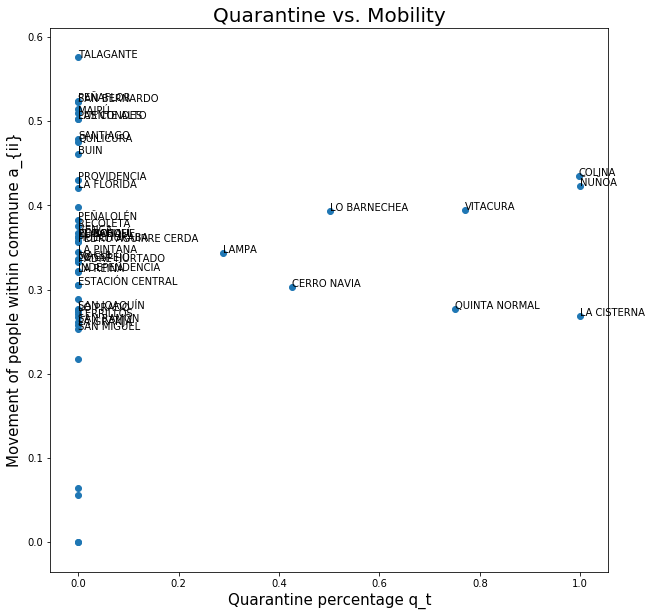

In [997]:
B = A[:,:,4:]
d = q[:,:5]

r = 4
at = np.diag(B[:,:,r])
dt = d[:,r]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(dt, at)
for i in range(dt.shape[0]):
    if com_pop[i,t] > 10000:
        name = dict_com_sid_com_info[i][1]
        point = [dt[i],at[i]]
        ax.text(dt[i], at[i], name)
ax.set_title('Quarantine vs. Mobility', size = 20)
ax.set_xlabel('Quarantine percentage q_t', size = 15)
ax.set_ylabel('Movement of people within commune a_{ii}', size = 15)
plt.show()

### Demographics

In [955]:
"""
Demographics information for all communes in Chile.
"""
df_demos.head()
print(list(enumerate(df_demos.columns)))

[(0, 'COMUNA'), (1, 'NOM_COMUNA'), (2, 'Densidad_'), (3, 'SUPERFICIE__KM2_'), (4, 'T_POB'), (5, 'T_HOM'), (6, 'T_MUJ'), (7, 'T_VIV'), (8, 'por_muj'), (9, 'por_hom'), (10, 'pers_viv'), (11, 'viv_km2_total'), (12, 'NOM_COMUNA.1'), (13, '0 a 4'), (14, '5 a 9'), (15, '10 a 14'), (16, '15 a 19'), (17, '20 a 24'), (18, '25 a 29'), (19, '30 a 34'), (20, '35 a 39'), (21, '40 a 44'), (22, '45 a 49'), (23, '50 a 54'), (24, '55 a 59'), (25, '60 a 64'), (26, '65 a 69'), (27, '70 a 74'), (28, '75 a 79'), (29, '80 a 84'), (30, '85 a 89'), (31, '90 a 94'), (32, '95 a 99'), (33, '100 o más')]


In [884]:
"""
Get demographic information for communes in Santiago.
"""
df_C = df_demos.copy()
df_C.loc[:,"COMUNA"] = df_C.loc[:,"COMUNA"].apply(get_com_sid)
df_C = df_C.dropna().sort_values("COMUNA")
df_C.drop(["COMUNA", "NOM_COMUNA", "NOM_COMUNA.1"], axis=1, inplace=True)

# Get demographics feature matrix
C = df_C.to_numpy()

In [885]:
# Demographics features over 51 communes in Santiago
print(C.shape)

(51, 31)


### Feature Extraction

In [940]:
# Feature extraction
def extract_features(A, q, y, params):
    """
    Extracts feature vectors for each sequential input.
    Returns a matrix of all features X[N,L,T] where X[:,:,t] is matrix of features for data at time t.
    """
    
    # get overlap of mobility data and infections data - hardcoded
    A = A[:,:,4:]
    y = y[:,:5]
    q = q[:,:5]
    
    
    N, T, L = params[:3]
    X = np.zeros((N, L, T))
    for t in range(T):
        At = A[:,:,t]
        yt = y[:,t]
        qt = q[:,t]
        
        x1 = np.diag(At)
        x2 = np.dot(At.T, np.ones(N))
        x3 = np.dot(At, np.ones(N))
        x4 = yt
        x5 = np.dot(At.T, yt)
        x6 = np.dot(At, yt)
        x7 = qt

        Xt = np.stack((x1,x2,x3,x4,x5,x6,x7), axis=-1)
        X[:,:,t] = Xt
    
#         x1 = yt
# #         x2 = qt
#         x2 = np.ones(N)*(t+1)
# #         Xt = np.stack((x1), axis=-1)
#         Xt = np.stack((x1,x2), axis=-1)
# # #         Xt = np.column_stack((Xt, C[:,2]))
# # #         Xt = np.stack((x1), axis=-1)
# #         X[:,:,t] = Xt.reshape((N,1))
#         X[:,:,t] = Xt
    
        
    return X, y

def collect_data(X, y, C, params):
    """
    Collects data into a big 'ol matrix and output matrix to feed into a regression method.
    """
    N, T, L, K, k, add_demos = params

    if add_demos:
        c = C.shape[1]
    else:
        c = 0
                  
    Z = np.zeros((N*(T-K), L*(K-k)+c))
    for t in range(T-K):
        Zt = X[:,:,t:t+K-k].transpose([0,2,1]).reshape((N, L*(K-k)))
        if add_demos:
            Zt = np.column_stack((Zt, C))
        Z[N*t:N*(t+1),:] = Zt
                 
    Y = np.zeros(N*(T-K))
    for t in range(T-K):
        Y[N*t:N*(t+1)] = y[:,t+K].reshape((N))
        
    return Z, Y

def timeseries_train_test_split(X, y, params):
    """
    Splits data into a train and test data.
    """
    N, T, L, K, k, _ = params
    n = 1                        # number of test points
    
    X_train = X[:N*(T-K-n),:]
    X_test = X[N*(T-K-n):,:]
    y_train = y[:N*(T-K-n)]
    y_test = y[N*(T-K-n):]
    
    return X_train, y_train, X_test, y_test

In [941]:
"""
Extract features
"""
N = 51                       # num communes
T = 5                        # num total data points

L = 7                        # num features added
K = 2                        # num lags
k = 0                        # num skips
# add_demos = False             # add demographic features
add_demos = True             # add demographic features
params = [N,T,L,K,k,add_demos]

F, y = extract_features(A, q, y, params)
X_data, y_data = collect_data(F, y, C, params)
X_train, y_train, X_test, y_test = timeseries_train_test_split(X_data, y_data, params)
print(F.shape, X_data.shape, y_data.shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(51, 7, 5) (153, 45) (153,)
(102, 45) (102,) (51, 45) (51,)


In [942]:
# print(F)
# # print(X_data, y_data)
# print(X_train)
# print(y_train)
# print(X_test)
# print(y_test)

### Linear Regression

In [943]:
reg = linear_model.LinearRegression(normalize=True)
reg.fit(X_train, y_train)
reg_rmse = np.sqrt(metrics.mean_squared_error(y_test, reg.predict(X_test)))

print("{:.2e}".format(reg_rmse))
print(reg.intercept_, reg.coef_)
print(reg.score(X_test, y_test))
print(y_test.mean())

2.91e+01
-1.0635743952219794e+16 [ 1.31616755e-03 -3.45469632e-04 -4.74291834e-05 -1.47810839e-01
 -4.60542552e-06  1.96621077e-06 -1.00472584e+01 -1.35354600e-03
  5.79505286e-04 -1.74324379e-04  1.28238253e+00 -3.58195931e-06
  5.90941831e-06  1.62728927e+01 -1.45086022e-03  3.04847266e-03
  4.41029417e+07  3.78529020e+07  3.78529020e+07 -1.47201923e-03
  1.06357440e+16  1.06357440e+16 -1.17944196e+01  7.76156243e-03
 -8.19558437e+07 -8.19558437e+07 -8.19558437e+07 -8.19558437e+07
 -8.19558437e+07 -8.19558437e+07 -8.19558437e+07 -8.19558437e+07
 -8.19558437e+07 -8.19558437e+07 -8.19558437e+07 -8.19558437e+07
 -8.19558437e+07 -8.19558437e+07 -8.19558437e+07 -8.19558437e+07
 -8.19558437e+07 -8.19558437e+07 -8.19558438e+07 -8.19558436e+07
 -8.19558439e+07]
0.9646852765954494
153.31372549019608


In [944]:
# y_pred = reg.predict(X_test)
# for i in range(len(y_test)):
#     commune_id = dict_sid_commune[i]
#     yi_act = y_test[i]
#     yi_pred = y_pred[i]
#     info_i = (commune_id, yi_act, yi_pred)
#     print(info_i)

### LASSO

In [945]:
lasso = linear_model.LassoCV(cv=model_selection.TimeSeriesSplit(n_splits=5), alphas=None, tol = 10000, normalize=True) 
lasso.fit(X_train, y_train)
optimal_alpha = lasso.alpha_
lasso2 = linear_model.Lasso(alpha=optimal_alpha, normalize=True)
lasso2.fit(X_train, y_train)
lasso2_rmse = np.sqrt(metrics.mean_squared_error(y_test, lasso2.predict(X_test)))

print("{:e}".format(lasso2_rmse))

2.471375e+01


In [947]:
print("{:.2e}".format(reg_rmse) + ' / ' + "{:.2e}".format(lasso2_rmse))

2.91e+01 / 2.47e+01


In [956]:
# Feature selection
fnames = []
for i in range(1,X_data.shape[1]+1):
    if 1 <= i <= L:
        fnames.append('x'+str(i)+'_2')
    elif L+1 <= i <= 2*L:
        fnames.append('x'+str(i-L)+'_1')
    else:
        fnames.append('c'+str(i-2*L))

print(lasso2.coef_)
print(lasso2.intercept_)
for pair in zip(fnames, lasso2.coef_):
    print(pair)

[ 2.92875881e-04 -0.00000000e+00  0.00000000e+00 -1.06413851e-01
 -5.54090903e-07 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -1.62318518e-04  0.00000000e+00  1.04666968e+00 -0.00000000e+00
  2.59031364e-06  2.17009735e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -8.38567477e+00  6.63806040e-03
  0.00000000e+00  3.27966778e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  4.53127114e-04  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -3.45935665e-03 -1.23798821e-03
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -9.30215819e-02]
20.667597580021862
('x1_2', 0.00029287588057551306)
('x2_2', -0.0)
('x3_2', 0.0)
('x4_2', -0.10641385114199012)
('x5_2', -5.540909031923529e-07)
('x6_2', -0.0)
('x7_2', -0.0)
('x1_1', 0.0)
('x2_1', -0.00016231851845687568)
('x3_1', 0.0)
('x4_1', 1.0466696791144632)
(

###### The following implementations are not finished yet...

### XGBoost

In [ ]:
X_train, y_train, X_test, y_test = timeseries_train_test_split(X=X, y=y)


scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

train_test_plot(model=xgb, X_train=X_train_scaled, X_test=X_test_scaled)


### Neural Network

In [ ]:
X_train, y_train, X_test, y_test = timeseries_train_test_split(X=X, y=y)

reg = neural_network.MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
reg.fit(X, y)

train_test_plot(model=reg, X_train=X_train_scaled, X_test=X_test_scaled)